In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/ANN

/gdrive/My Drive/ANN


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.keras import layers
from tensorflow.keras import regularizers

#from tensorflow.keras.applications.EfficientNetV2L import preprocess_input


In [4]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 4.7 MB/s 


In [5]:
seed = 21

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [7]:
dataset_dir = "Dataset/splitted_cleaned_by_Alberto"
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [8]:
labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

In [9]:
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=0.4,
                                        width_shift_range=0.4,
                                        zoom_range=0.4,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect'
                                        #rescale=1/255.,
                                        #preprocessing_function = preprocess_input
                                        )

aug_val_data_gen = ImageDataGenerator(rotation_range=180,
                                      height_shift_range=0.4,
                                      width_shift_range=0.4,
                                      zoom_range=0.4,
                                      horizontal_flip=True,
                                      vertical_flip=True, 
                                      fill_mode='reflect'
                                      #rescale=1/255.,
                                      #preprocessing_function = preprocess_input
                                      )
test_data_gen = ImageDataGenerator(#preprocessing_function = preprocess_input
                                   )

In [10]:
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)
aug_val_gen = aug_val_data_gen.flow_from_directory(directory=validation_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=False,
                                                       seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=8,
                                             shuffle=False,
                                             seed=seed)

Found 3060 images belonging to 8 classes.
Found 571 images belonging to 8 classes.
Found 197 images belonging to 8 classes.


In [11]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join("Models/EfficientNet/Checkpoints")
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [12]:
#def create_class_weight(labels_dict,mu=0.15):
#    total = np.sum(list(labels_dict.values()))
#    keys = labels_dict.keys()
#    class_weight = dict()
    
#    for key in keys:
#        score = math.log(total/float(labels_dict[key]))
#        class_weight[key] = score if score > 1.0 else 1.0
    
#    return class_weight

#labels_dict = {0: 1.7458, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1.568, 6: 1, 7: 1} 
#class_weights = create_class_weight(labels_dict)
#class_weights

In [13]:
input_shape = (96, 96, 3)
epochs = 200

In [14]:
ft_model = tfk.models.load_model("Models/EfficientNet/TransferLearning")
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 3, 3, 1280)       117746848 
 l)                                                              
                                                                 
 Flattening (Flatten)        (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [18]:
# Set all VGG layers to True
ft_model.get_layer('efficientnetv2-l').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-l').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 stem_conv True
3 stem_bn True
4 stem_activation True
5 block1a_project_conv True
6 block1a_project_bn True
7 block1a_project_activation True
8 block1a_add True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block1c_project_conv True
15 block1c_project_bn True
16 block1c_project_activation True
17 block1c_drop True
18 block1c_add True
19 block1d_project_conv True
20 block1d_project_bn True
21 block1d_project_activation True
22 block1d_drop True
23 block1d_add True
24 block2a_expand_conv True
25 block2a_expand_bn True
26 block2a_expand_activation True
27 block2a_project_conv True
28 block2a_project_bn True
29 block2b_expand_conv True
30 block2b_expand_bn True
31 block2b_expand_activation True
32 block2b_project_conv True
33 block2b_project_bn True
34 block2b_drop True
35 block2b_add True
36 block2c_expand_conv True
37 block2c_expand_bn True
38 block2c_expand_activation

In [21]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-l').layers[:250]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-l').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block1d_project_conv False
20 block1d_project_bn False
21 block1d_project_activation False
22 block1d_drop False
23 block1d_add False
24 block2a_expand_conv False
25 block2a_expand_bn False
26 block2a_expand_activation False
27 block2a_project_conv False
28 block2a_project_bn False
29 block2b_expand_conv False
30 block2b_expand_bn False
31 block2b_expand_activation False
32 block2b_project_conv False
33 block2b_project_bn False
34 block2b_drop False
35 block2b_add False
36 block2c_expand_conv False
37 block2c_expand

In [22]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.5e-4), metrics='accuracy')

In [23]:
ft_callbacks = create_folders_and_callbacks(model_name='EfficientNet_FT')

ft_history = ft_model.fit(
     x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_val_gen,
    callbacks = ft_callbacks,
    class_weight = {0: 1.7458, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1.568, 6: 1, 7: 1} 
).history

Epoch 1/200
383/383 [==============================] - 2132s 5s/step - loss: 1.9135 - accuracy: 0.3850 - val_loss: 1.3342 - val_accuracy: 0.4956
Epoch 2/200
383/383 [==============================] - 2022s 5s/step - loss: 1.5545 - accuracy: 0.4961 - val_loss: 1.1668 - val_accuracy: 0.5814
Epoch 3/200
383/383 [==============================] - 2053s 5s/step - loss: 1.4076 - accuracy: 0.5493 - val_loss: 0.9371 - val_accuracy: 0.6550
Epoch 4/200
383/383 [==============================] - 2140s 6s/step - loss: 1.2709 - accuracy: 0.5908 - val_loss: 0.9414 - val_accuracy: 0.6673
Epoch 5/200
383/383 [==============================] - 2107s 6s/step - loss: 1.2096 - accuracy: 0.6088 - val_loss: 0.8241 - val_accuracy: 0.6883
Epoch 6/200
383/383 [==============================] - 2109s 6s/step - loss: 1.1563 - accuracy: 0.6288 - val_loss: 0.7683 - val_accuracy: 0.7373
Epoch 7/200
383/383 [==============================] - 2105s 5s/step - loss: 1.0884 - accuracy: 0.6536 - val_loss: 0.8095 - val_ac

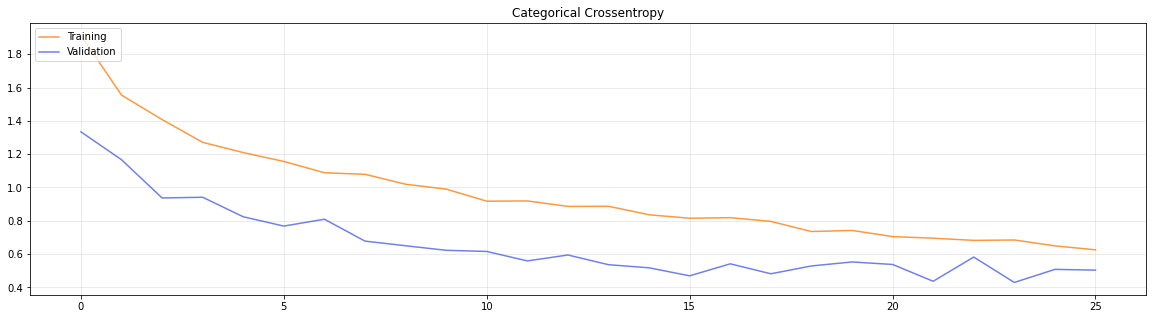

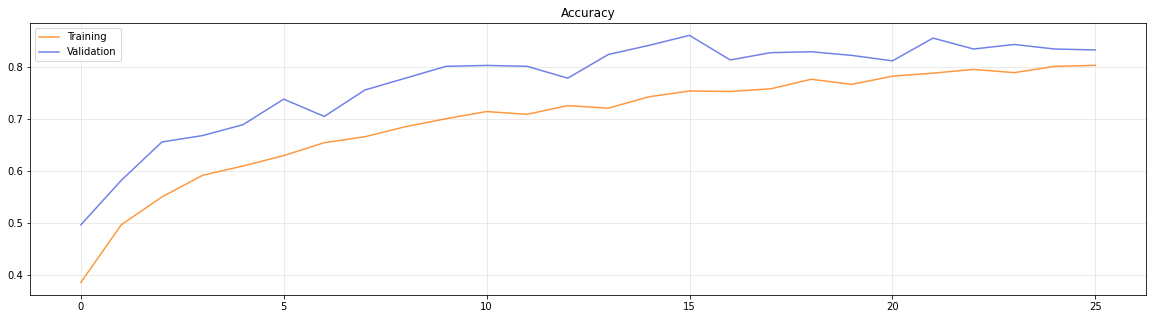

In [24]:
plt.figure(figsize=(20,5))
plt.plot(ft_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(ft_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(ft_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(ft_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [26]:
predictions = ft_model.predict(test_gen)
predictions.shape
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   

25/25 [==============================] - 46s 1s/step


Accuracy: 0.8376


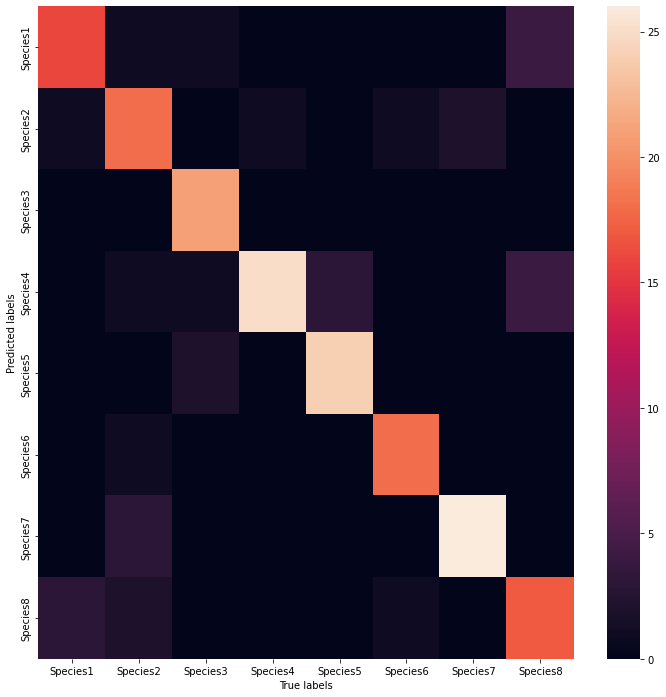

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
#precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
#print('Precision:',precision.round(4))
#print('Recall:',recall.round(4))
#print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm.T, xticklabels=list(class_labels), yticklabels=list(class_labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [30]:
ft_model.save("Models/EfficientNet/FineTuning")